# Bahdanau 注意力
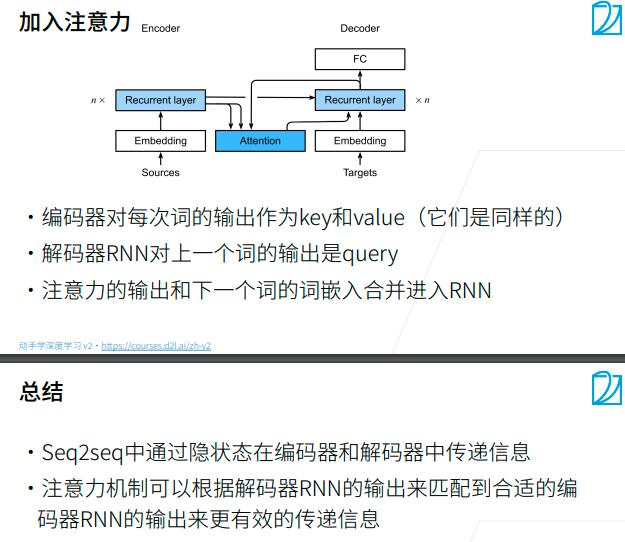

In [6]:
# 解决内核挂掉的问题
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch import nn
from d2l import torch as d2l

带有注意力机制的解码器基本接口

In [7]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

实现带有Bahdanau注意力的循环神经网络解码器

In [8]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout) # 注意力层，实际上就是把k,v,q传入，。。。
        self.embedding = nn.Embedding(vocab_size, embed_size) # 把token转换乘数字
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout) # GRU层
        self.dense = nn.Linear(num_hiddens, vocab_size) # 全连接层

    def init_state(self, enc_outputs, enc_valid_lens, *args): # 解码器的初始隐藏状态
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1) # 解码器最后一个隐藏状态，
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens) # 把k,v,q送入注意力层，得到解码器的输入（上下文信息）
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1) # 将上下文信息和解码器的真实输入拼接起来
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) # 送入rnn得到最终解码器的输出
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [
            enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

测试Bahdanau 注意力解码器

In [9]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

训练

loss 0.023, 7117.3 tokens/sec on cuda:0


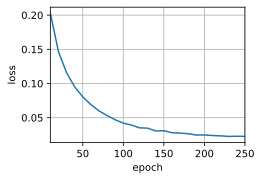

In [10]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                             num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                  num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

将几个英语句子翻译成法语

In [11]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [12]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
        (1, 1, -1, num_steps))

可视化注意力权重

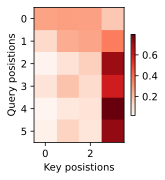

In [13]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key posistions', ylabel='Query posistions')